In [1]:
!pip -q install nnunetv2 nibabel tifffile simpleitk


Create nnU-Net folders

In [2]:
import os

BASE = "/data/nnunet"  # change to "/app/nnunet" if you DON'T have persistent storage
RAW = f"{BASE}/nnUNet_raw"
PREP = f"{BASE}/nnUNet_preprocessed"
RES = f"{BASE}/nnUNet_results"

for p in [RAW, PREP, RES]:
    os.makedirs(p, exist_ok=True)

print("Created:", RAW, PREP, RES)


Created: /data/nnunet/nnUNet_raw /data/nnunet/nnUNet_preprocessed /data/nnunet/nnUNet_results


In [3]:
import os
os.environ["nnUNet_raw"] = RAW
os.environ["nnUNet_preprocessed"] = PREP
os.environ["nnUNet_results"] = RES
print("env set")


env set


In [4]:
!pip -q install huggingface_hub


In [5]:
from huggingface_hub import snapshot_download

ds_path = snapshot_download(
    repo_id="thecodex/KSSD2025KidneyStoneSegmentationDataset",
    repo_type="dataset",
    local_dir="/data/KSSD2025",
    max_workers=1,          # VERY IMPORTANT (slower but stable)
    etag_timeout=300        # increase timeout
)

print("Downloaded to:", ds_path)


Fetching ... files: 0it [00:00, ?it/s]

Downloaded to: /data/KSSD2025


In [6]:
!pip install -U huggingface_hub tqdm


In [7]:
import os

print("Top-level files:", os.listdir(ds_path)[:20])


Top-level files: ['.cache', 'dataset', '.gitattributes', 'README.md']


In [8]:
for root, dirs, files in os.walk(ds_path):
    if files:
        print(root)
        print(files[:10])
        break


/data/KSSD2025
['.gitattributes', 'README.md']


In [9]:
!du -sh /data/KSSD2025
!find /data/KSSD2025 -maxdepth 3 -type f | head -n 50


302M	/data/KSSD2025
/data/KSSD2025/.cache/huggingface/.gitignore
/data/KSSD2025/dataset/image/1.tif
/data/KSSD2025/dataset/image/10.tif
/data/KSSD2025/dataset/image/1012.tif
/data/KSSD2025/dataset/image/1013.tif
/data/KSSD2025/dataset/image/1003.tif
/data/KSSD2025/dataset/image/1002.tif
/data/KSSD2025/dataset/image/1014.tif
/data/KSSD2025/dataset/image/1001.tif
/data/KSSD2025/dataset/image/1000.tif
/data/KSSD2025/dataset/image/1021.tif
/data/KSSD2025/dataset/image/1020.tif
/data/KSSD2025/dataset/image/1022.tif
/data/KSSD2025/dataset/image/1023.tif
/data/KSSD2025/dataset/image/1015.tif
/data/KSSD2025/dataset/image/1026.tif
/data/KSSD2025/dataset/image/1027.tif
/data/KSSD2025/dataset/image/1029.tif
/data/KSSD2025/dataset/image/1025.tif
/data/KSSD2025/dataset/image/1032.tif
/data/KSSD2025/dataset/image/1033.tif
/data/KSSD2025/dataset/image/1035.tif
/data/KSSD2025/dataset/image/1031.tif
/data/KSSD2025/dataset/image/1037.tif
/data/KSSD2025/dataset/image/1038.tif
/data/KSSD2025/dataset/image

In [10]:
!ls /data/KSSD2025/dataset


image  label


In [11]:
!ls /data/KSSD2025/dataset/label | head


1.tif
10.tif
1000.tif
1001.tif
1002.tif
1003.tif
1012.tif
1013.tif
1014.tif
1015.tif
ls: write error: Broken pipe


In [12]:
import os

BASE = "/data/nnUNet"
RAW = f"{BASE}/nnUNet_raw"

os.makedirs(RAW, exist_ok=True)

DATASET_ID = 501
DATASET_NAME = "KSSD"
nn_folder = f"{RAW}/Dataset{DATASET_ID:03d}_{DATASET_NAME}"

imagesTr = f"{nn_folder}/imagesTr"
labelsTr = f"{nn_folder}/labelsTr"

os.makedirs(imagesTr, exist_ok=True)
os.makedirs(labelsTr, exist_ok=True)

print("Created:", nn_folder)


Created: /data/nnUNet/nnUNet_raw/Dataset501_KSSD


In [13]:
os.environ["nnUNet_raw"] = RAW
os.environ["nnUNet_preprocessed"] = f"{BASE}/nnUNet_preprocessed"
os.environ["nnUNet_results"] = f"{BASE}/nnUNet_results"

for k in ["nnUNet_raw","nnUNet_preprocessed","nnUNet_results"]:
    print(k, "=", os.environ[k])


nnUNet_raw = /data/nnUNet/nnUNet_raw
nnUNet_preprocessed = /data/nnUNet/nnUNet_preprocessed
nnUNet_results = /data/nnUNet/nnUNet_results


In [14]:
# # — Convert .tif → .nii.gz (this is the core step)
# Key rules (nnU-Net strictness):

# Images: case_xxxx_0000.nii.gz

# Labels: case_xxxx.nii.gz

# Same ordering image ↔ label

# Conversion code (TAILORED to your dataset)

In [15]:
import glob
import tifffile as tiff
import nibabel as nib
import numpy as np

img_files = sorted(glob.glob("/data/KSSD2025/dataset/image/*.tif"))
lbl_files = sorted(glob.glob("/data/KSSD2025/dataset/label/*.tif"))

print("Images:", len(img_files))
print("Labels:", len(lbl_files))

assert len(img_files) == len(lbl_files), "Image/label count mismatch!"


Images: 838
Labels: 838


for i, (img_p, lbl_p) in enumerate(zip(img_files, lbl_files)):
    img = tiff.imread(img_p)
    lbl = tiff.imread(lbl_p)

    img = np.asarray(img, dtype=np.float32)
    lbl = np.asarray(lbl, dtype=np.uint8)

    # ensure shape consistency
    if img.ndim == 2:
        img = img[..., None]
    if lbl.ndim == 2:
        lbl = lbl[..., None]

    affine = np.eye(4)
    case_id = f"case_{i:04d}"

    nib.save(
        nib.Nifti1Image(img, affine),
        f"{imagesTr}/{case_id}_0000.nii.gz"
    )
    nib.save(
        nib.Nifti1Image(lbl, affine),
        f"{labelsTr}/{case_id}.nii.gz"
    )

print("Conversion complete.")


Create dataset.json (minimal + correct)

Before this, we must confirm label values.

In [16]:
import numpy as np
import tifffile as tiff

sample = tiff.imread(lbl_files[0])
np.unique(sample)


array([  0,   1,   2,   3,   4,   5, 251, 252, 253, 254, 255], dtype=uint8)

import numpy as np, tifffile as tiff
from collections import Counter

m = tiff.imread(lbl_files[0])
vals, counts = np.unique(m, return_counts=True)

for v, c in sorted(zip(vals, counts), key=lambda x: -x[1])[:20]:
    print(int(v), int(c))


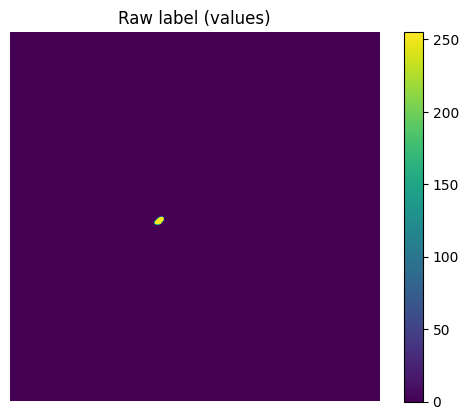

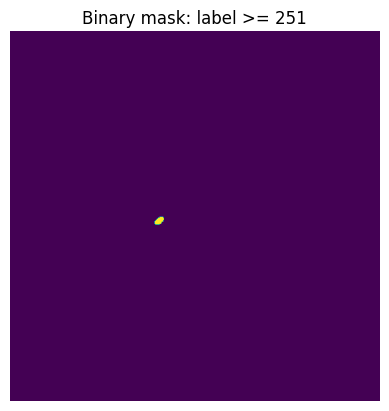

In [17]:
import matplotlib.pyplot as plt
import numpy as np, tifffile as tiff

m = tiff.imread(lbl_files[0])

plt.figure()
plt.imshow(m)
plt.title("Raw label (values)")
plt.axis("off")
plt.colorbar()
plt.show()

# Show a binary version using high values (251-255) as foreground
m_bin = (m >= 251).astype(np.uint8)

plt.figure()
plt.imshow(m_bin)
plt.title("Binary mask: label >= 251")
plt.axis("off")
plt.show()


Do the safe remap to binary (recommended for “stone vs background”)

This produces clean labels for nnU-Net.

In [18]:
import glob
import tifffile as tiff
import nibabel as nib
import numpy as np

img_files = sorted(glob.glob("/data/KSSD2025/dataset/image/*.tif"))
lbl_files = sorted(glob.glob("/data/KSSD2025/dataset/label/*.tif"))

assert len(img_files) == len(lbl_files), "Image/label count mismatch!"

for i, (img_p, lbl_p) in enumerate(zip(img_files, lbl_files)):
    img = tiff.imread(img_p).astype(np.float32)
    lbl = tiff.imread(lbl_p).astype(np.uint8)

    # --- IMPORTANT: remap label to clean binary ---
    # stone = any pixel value >= 251
    lbl = (lbl >= 251).astype(np.uint8)

    # ensure dims
    if img.ndim == 2:
        img = img[..., None]
    if lbl.ndim == 2:
        lbl = lbl[..., None]

    affine = np.eye(4)
    case_id = f"case_{i:04d}"

    nib.save(nib.Nifti1Image(img, affine), f"{imagesTr}/{case_id}_0000.nii.gz")
    nib.save(nib.Nifti1Image(lbl, affine), f"{labelsTr}/{case_id}.nii.gz")

print("Conversion complete with binary remap (>=251 -> 1).")


Conversion complete with binary remap (>=251 -> 1).


In [19]:
import nibabel as nib, numpy as np, glob

sample_lbl = glob.glob(labelsTr + "/*.nii.gz")[0]
arr = nib.load(sample_lbl).get_fdata()
print("Unique label values:", np.unique(arr))


Unique label values: [0. 1.]


In [20]:
import json, glob

dataset_json = {
  "channel_names": {"0": "CT"},
  "labels": {"background": 0, "stone": 1},
  "numTraining": len(glob.glob(imagesTr + "/*.nii.gz")),
  "file_ending": ".nii.gz"
}

with open(f"{nn_folder}/dataset.json", "w") as f:
    json.dump(dataset_json, f, indent=2)

print("dataset.json written")


dataset.json written


In [21]:
!pip install blosc2


In [22]:
import os

os.environ["nnUNet_raw"] = "/data/nnUNet/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/data/nnUNet/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/data/nnUNet/nnUNet_results"

for k in ["nnUNet_raw","nnUNet_preprocessed","nnUNet_results"]:
    print(k, "=", os.environ[k])


nnUNet_raw = /data/nnUNet/nnUNet_raw
nnUNet_preprocessed = /data/nnUNet/nnUNet_preprocessed
nnUNet_results = /data/nnUNet/nnUNet_results


In [23]:
!pip uninstall -y blosc2 numpy


Found existing installation: blosc2 2.2.8
Uninstalling blosc2-2.2.8:
  Successfully uninstalled blosc2-2.2.8
Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4


In [24]:
!pip install numpy==1.24.4


  Using cached numpy-1.24.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)


In [25]:
!pip install blosc2==2.2.8


  Using cached blosc2-2.2.8-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)


In [26]:
import numpy
print(numpy.__version__)


1.24.4


In [27]:
import numpy
print(numpy.__version__)


1.24.4


In [28]:
import blosc2
print("blosc2 imported successfully")


blosc2 imported successfully


In [29]:
# Re-set nnU-Net environment variables

In [30]:
import os

os.environ["nnUNet_raw"] = "/data/nnUNet/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/data/nnUNet/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/data/nnUNet/nnUNet_results"

for k in ["nnUNet_raw","nnUNet_preprocessed","nnUNet_results"]:
    print(k, os.environ[k])


nnUNet_raw /data/nnUNet/nnUNet_raw
nnUNet_preprocessed /data/nnUNet/nnUNet_preprocessed
nnUNet_results /data/nnUNet/nnUNet_results


In [31]:
!nnUNetv2_plan_and_preprocess -d 501 --verify_dataset_integrity

Fingerprint extraction...
Dataset501_KSSD
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100%|█████████████████████████████████████████| 838/838 [00:28<00:00, 29.40it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 14, 'patch_size': (512, 448), 'median_image_size_in_voxels': array([512., 416.]), 'spacing': array([1., 1.]), 'normalization_schem

In [32]:
!nvidia-smi


/bin/bash: nvidia-smi: command not found


In [33]:
# Start training (Fold 0)

In [34]:
!nnUNetv2_train 501 2d 0



############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0
/home/user/miniconda/lib/python3.9/site-packages/nnunetv2/training/nnUNetTrainer/nnUNetTrainer.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None
/home/user/miniconda/lib/python3.9/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). n

In [ ]:
!bash -lc "export CUDA_VISIBLE_DEVICES=''; nnUNetv2_train 501 2d 0"
